<h1 style="text-align: center;"><strong>Análisis exploratorio de datos (EDA)</strong></h1>


> # Etapa 1: Análisis descriptivo 
----------

- Instalación de librerias

In [1]:
# %pip install pyodbc
# %pip install ipython
# %pip install edaSQL       
# %pip install pandas
# %pip install numpy
# %pip install matplotlib.pyplot
# %pip install seaborn 
# %pip install scipy

1. __Importamos los paquetes necesarios__

In [2]:
import edaSQL # conexión a base datos
import pandas as pd
import numpy as np
import seaborn as sns # visualización
import matplotlib.pyplot as plt # visualización
from scipy import stats # Datos atípicos


2.  __Establecer conexión con base datos__

In [3]:
try:
    edasql = edaSQL.SQL(printAll=True)

    edasql.connectToDataBase(
        server="localhost",
        database="TecnoNicBD",
        user="sa",
        password="password",
        sqlDriver="ODBC Driver 17 for SQL Server"
    )
except Exception as e:
    print("A ocurrido un error con:", e)

========== Connected to DataBase Successfully ===========
Server:  localhost
DataBase:  TecnoNicBD
User :  sa
Password :  password


2. __Cargamos la data en “dataframes”__

In [4]:
# Función para cargar las tablas a un dataframe
def loadTable(table_name):
    query = f"SELECT * FROM {table_name}"
    return pd.read_sql(query, edasql.dbConnection)

# Cargar las tablas en DataFrames
df_cliente = loadTable("dbo.DimensionCliente")
df_AreaEnvio = loadTable("dbo.DimensionAreaEnvio")
df_ofertas = loadTable("dbo.DimensionOfertas")
df_pedido = loadTable("dbo.DimensionPedido")
df_producto = loadTable("dbo.DimensionProducto")
df_tiempo = loadTable("dbo.DimensionTiempo")
df_ubicacion = loadTable("dbo.DimensionUbicacion")
df_envio = loadTable("dbo.FactTableEnvio")

- Se fusionaron los conjuntos de datos para estructurar la información.

In [5]:
df_envio = df_envio \
    .merge(df_cliente, left_on='ClienteId', right_on='ClienteId', how='left', suffixes=('', '_cliente')) \
    .merge(df_ofertas, left_on='OfertasId', right_on='Ofertasid', how='left', suffixes=('', '_ofertas')) \
    .merge(df_AreaEnvio, left_on='AreaEnvioId', right_on='AreaEnvioId', how='left', suffixes=('', '_area')) \
    .merge(df_pedido, left_on='PedidoId', right_on='PedidoId', how='left', suffixes=('', '_pedido')) \
    .merge(df_producto, left_on='ProductoId', right_on='ProductoId', how='left', suffixes=('', '_producto')) \
    .merge(df_tiempo, left_on='DATAKEY', right_on='DateId', how='left', suffixes=('', '_tiempo')) \
    .merge(df_ubicacion, left_on='UbicacionId', right_on='UbicacionId', how='left', suffixes=('', '_ubicacion'))

- Definir índice

In [6]:
df_envio = df_envio.set_index("EnviosID")

- Limpieza de datos

In [7]:
# Definir nombre completo del cliente
df_envio['NombreCliente'] = df_envio['Nombre'] + ' ' + df_envio['Apellido']
df_envio.drop(columns=["Nombre", "Apellido"], inplace=True)

- Eliminar columnas innecesarias

In [8]:
toRemove = [
    'FechaAgregado',
    'ValidTo',
    'ValidFrom',
    'FechaLanzamiento',
    'Direccion',
    'Ciudad',
    'Pais',
    'Estado',
    'FechaCaducidad',
    'CodDescuento',
    'Descripcion',
    'Email',
    'Telefono'
    'DATAKEY'
]

# filtrar columas
columsDrop = [
    col
    for col in df_envio.columns
    if col.endswith('Id') or col.endswith('ID') or col.endswith('id')
    or col.startswith('FechaInicio')
    or col.startswith('FechaFin')
    or any(keyword in col for keyword in toRemove)
]

# Eliminar las columnas obtenidas del DataFrame original para realizar la limpieza de datos
df_envio.drop(columns=columsDrop, inplace=True)

- Organizar dataframe

In [9]:
columnOrder = [
    'NombreCliente','PuntosFidelidad', 'CodigoPostal', # Cliente
    'EmpresaEnvio', 'MetodoEnvio', 'NombreArea', 'CostoEnvio', # Envio 
    'FechaEnvio', 'FechaEntrega', 'FechaPedido', # Fechas importantes
    'Nombre_producto', 'Dimensiones', 'Peso','Nombrecategoria', 'NombreMarca', # producto
    'PrecioUnitario','Cantidad','NombreMetodoPago','Nombre_ofertas','Descuento' # pedido
]

# Ordenar las columnas del DataFrame
df_envio = df_envio[columnOrder]
df_envio.columns

Index(['NombreCliente', 'PuntosFidelidad', 'CodigoPostal', 'EmpresaEnvio',
       'MetodoEnvio', 'NombreArea', 'CostoEnvio', 'FechaEnvio', 'FechaEntrega',
       'FechaPedido', 'Nombre_producto', 'Dimensiones', 'Peso',
       'Nombrecategoria', 'NombreMarca', 'PrecioUnitario', 'Cantidad',
       'NombreMetodoPago', 'Nombre_ofertas', 'Descuento'],
      dtype='object')

3. __Características de un DataFrame__ 


- Mostrar las primeras filas

In [10]:
df_envio.head(5) 

,NombreCliente,PuntosFidelidad,CodigoPostal,EmpresaEnvio,MetodoEnvio,NombreArea,CostoEnvio,FechaEnvio,FechaEntrega,FechaPedido,Nombre_producto,Dimensiones,Peso,Nombrecategoria,NombreMarca,PrecioUnitario,Cantidad,NombreMetodoPago,Nombre_ofertas,Descuento
EnviosID,,,,,,,,,,,,,,,,,,,,
1,Margalit Dacres,86,53770,DHL,envio estandar,Area E,139.97,2023-07-28,2023-06-28,2023-01-27,smartphone,10x5x3,1137.12,ElectroGuru,Lenovo,761.64,31,Cash,Oferta de Primavera,12.33
2,Marietta Endicott,17,24676,DHL,envio prioritario,Area E,139.97,2023-06-21,2023-07-16,2023-07-20,portable charger,8x8x8,5246.84,TechWiz,Sony,444.44,12,Cash,Oferta de Otoño,33.12
3,Hailee Grimestone,86,22158,UPS,envio prioritario,Area A,136.95,2023-05-15,2023-02-10,2023-04-05,smart home device,12x6x4,4140.23,ElectroWorld,Microsoft,218.06,8,Cash,Oferta de Verano,11.98
4,Asher McGougan,90,11614,Correos,envio express,Area B,112.06,2023-12-24,2023-03-08,2023-06-17,laptop,10x5x3,5821.57,ElectroWorld,Acer,47.45,24,Venmo,Oferta de Otoño,33.12
5,Margalit Penke,13,18987,Correos,envio prioritario,Area E,139.97,2023-03-07,2023-06-01,2023-03-29,portable charger,8x8x8,5246.84,TechWiz,Sony,632.79,45,PayPal,Oferta de Otoño,33.12


- Mostrar las ultimas filas

In [11]:
df_envio.tail(5) 

,NombreCliente,PuntosFidelidad,CodigoPostal,EmpresaEnvio,MetodoEnvio,NombreArea,CostoEnvio,FechaEnvio,FechaEntrega,FechaPedido,Nombre_producto,Dimensiones,Peso,Nombrecategoria,NombreMarca,PrecioUnitario,Cantidad,NombreMetodoPago,Nombre_ofertas,Descuento
EnviosID,,,,,,,,,,,,,,,,,,,,
646,Nathaniel Austing,100,68112,DHL,envio estandar,Area A,138.82,2023-07-31,2023-06-10,2023-06-03,laptop,10x5x3,5821.57,ElectroWorld,Acer,615.22,27,Debit Card,Oferta de Otoño,33.12
647,Verina Beazey,40,25274,Correos,envio estandar,Area B,196.41,2023-12-08,2023-07-20,2023-06-28,laptop,10x5x3,5821.57,ElectroWorld,Acer,17.62,29,Credit Card,Oferta de Verano,11.98
648,Angelita Akroyd,26,85690,Correos,envio prioritario,Area B,196.41,2023-05-01,2023-06-29,2023-06-08,smartphone,8x8x8,9570.71,InnoTech,HP,272.39,42,PayPal,Oferta de Verano,11.98
649,Jobina Mustarde,68,106749,Correos,envio prioritario,Area A,136.95,2023-02-19,2023-04-05,2023-06-05,smartphone,15x10x5,346.17,GizmoGalaxy,Sony,891.53,18,Debit Card,Oferta de Verano,11.98
650,Cassey Buckler,53,63837,UPS,envio prioritario,Area B,112.06,2023-07-03,2023-02-08,2023-04-30,laptop,10x5x3,5821.57,ElectroWorld,Acer,969.06,38,PayPal,Oferta de Invierno,34.68


- Mostrar el número de filas y columnas del DataFrame ventas. 

In [12]:
print(f"Número de filas del dataframe: {df_envio.shape[0]} \nNúmero de columnas del dataframe: {df_envio.shape[1]}")

Número de filas del dataframe: 650 
Número de columnas del dataframe: 20


-  Resumen de la información interna sobre el DataFrame.

In [13]:
df_envio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 650 entries, 1 to 650
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   NombreCliente     650 non-null    object        
 1   PuntosFidelidad   650 non-null    int64         
 2   CodigoPostal      650 non-null    int64         
 3   EmpresaEnvio      650 non-null    object        
 4   MetodoEnvio       650 non-null    object        
 5   NombreArea        650 non-null    object        
 6   CostoEnvio        650 non-null    float64       
 7   FechaEnvio        650 non-null    datetime64[ns]
 8   FechaEntrega      650 non-null    datetime64[ns]
 9   FechaPedido       650 non-null    datetime64[ns]
 10  Nombre_producto   650 non-null    object        
 11  Dimensiones       650 non-null    object        
 12  Peso              650 non-null    float64       
 13  Nombrecategoria   650 non-null    object        
 14  NombreMarca       650 non-null 

- Análisis descriptivos

In [14]:
columns = [col for col in df_envio.columns if col != 'CodigoPostal']
df_envio[columns].describe() 

,PuntosFidelidad,CostoEnvio,FechaEnvio,FechaEntrega,FechaPedido,Peso,PrecioUnitario,Cantidad,Descuento
count,650.000000,650.000000,650,650,650,650.000000,650.000000,650.000000,650.000000
mean,50.549231,151.958338,2023-07-02 20:31:45.230769152,2023-04-16 06:56:29.538461440,2023-04-06 22:46:53.538461440,4320.672492,475.914677,25.543077,22.930815
min,0.000000,103.980000,2023-01-03 00:00:00,2023-01-02 00:00:00,2023-01-01 00:00:00,346.170000,1.240000,0.000000,11.980000
25%,24.000000,136.950000,2023-03-31 00:00:00,2023-02-25 00:00:00,2023-02-14 00:00:00,1137.120000,238.760000,13.000000,11.980000
50%,50.000000,139.970000,2023-07-02 00:00:00,2023-04-14 12:00:00,2023-04-09 00:00:00,4140.230000,443.160000,25.000000,12.330000
75%,77.000000,169.990000,2023-10-08 00:00:00,2023-06-02 00:00:00,2023-05-23 18:00:00,5821.570000,724.690000,39.000000,34.680000
max,100.000000,196.410000,2023-12-30 00:00:00,2023-07-31 00:00:00,2023-07-28 00:00:00,9570.710000,993.530000,50.000000,34.680000
std,29.797440,26.986088,NaN,NaN,NaN,2903.452656,289.721190,14.812609,10.910520


### Informe Estadístico de Pedidos y Envíos

#### Introducción
Este informe presenta un análisis estadístico de un conjunto de datos relacionado con pedidos y envíos. El objetivo es proporcionar una visión general de las características clave de los datos, identificar patrones y variabilidad, y extraer conclusiones útiles para futuras decisiones empresariales.

#### Resumen de Estadísticas Descriptivas

Las estadísticas descriptivas para las variables analizadas se detallan a continuación:

1. **Puntos de Fidelidad**:
   - **Media**: 50.55 puntos.
   - **Rango**: 0 a 100 puntos.
   - **Mediana**: 50 puntos.
   - **Desviación Estándar**: 29.80.
   - **Interpretación**: Los puntos de fidelidad muestran una distribución simétrica con una variabilidad moderada.

2. **Costo de Envío**:
   - **Media**: 151.96 unidades monetarias.
   - **Rango**: 103.98 a 196.41 unidades monetarias.
   - **Mediana**: 139.97 unidades monetarias.
   - **Desviación Estándar**: 26.99.
   - **Interpretación**: Los costos de envío presentan una ligera distribución sesgada a la derecha con una variabilidad moderada.

3. **Fechas**:
   - **Fecha de Envío Media**: 2023-07-02.
   - **Fecha de Entrega Media**: 2023-04-16.
   - **Fecha de Pedido Media**: 2023-04-06.
   - **Interpretación**: Las fechas de envío y entrega están distribuidas a lo largo del año 2023, mostrando actividad continua en las operaciones de envío.

4. **Peso**:
   - **Media**: 4320.67 unidades.
   - **Rango**: 346.17 a 9570.71 unidades.
   - **Mediana**: 4140.23 unidades.
   - **Desviación Estándar**: 2903.45.
   - **Interpretación**: El peso de los envíos varía significativamente, indicando diversidad en los productos enviados.

5. **Precio Unitario**:
   - **Media**: 475.91 unidades monetarias.
   - **Rango**: 1.24 a 993.53 unidades monetarias.
   - **Mediana**: 443.16 unidades monetarias.
   - **Desviación Estándar**: 289.72.
   - **Interpretación**: Los precios unitarios presentan alta variabilidad, reflejando una amplia gama de productos vendidos.

6. **Cantidad**:
   - **Media**: 25.54 unidades.
   - **Rango**: 0 a 50 unidades.
   - **Mediana**: 25 unidades.
   - **Desviación Estándar**: 14.81.
   - **Interpretación**: La cantidad de productos en los pedidos es bastante uniforme, con una distribución simétrica.

7. **Descuento**:
   - **Media**: 22.93 unidades monetarias.
   - **Rango**: 11.98 a 34.68 unidades monetarias.
   - **Mediana**: 12.33 unidades monetarias.
   - **Desviación Estándar**: 10.91.
   - **Interpretación**: Los descuentos muestran una ligera distribución sesgada a la derecha, con una variabilidad moderada.

#### Conclusiones Generales

- **Fechas de Envío y Entrega**: Las fechas de envío y entrega están distribuidas a lo largo del año, con una media en julio para envíos y en abril para entregas. Esto podría indicar un desfase en la recogida de datos o la naturaleza de los pedidos.
- **Puntos de Fidelidad y Descuento**: Ambas variables muestran una distribución equilibrada dentro de los rangos esperados, lo que sugiere que los clientes obtienen recompensas y descuentos de manera consistente.
- **Costo y Peso de Envío**: La alta variabilidad en los costos y pesos de envío indica diferencias significativas en los tipos de pedidos, lo que podría implicar una variedad de productos y destinos.
- **Precio Unitario y Cantidad**: La alta variabilidad en los precios unitarios y cantidades sugiere que los productos vendidos varían significativamente en términos de precio y cantidad.

#### Recomendaciones

1. **Optimización de Costos**: Considerar estrategias para reducir la variabilidad en los costos de envío, posiblemente mediante la negociación con proveedores de servicios de logística.
2. **Programas de Fidelización**: Continuar incentivando a los clientes a través de puntos de fidelidad y descuentos, manteniendo la equidad y consistencia en las recompensas.
3. **Análisis de Productos**: Realizar un análisis más detallado de los productos para identificar aquellos con alta variabilidad en precios y pesos, y ajustar las estrategias de inventario y marketing en consecuencia.

- Elimanr columnas innecesarias

In [15]:
df_envio = df_envio.drop(columns=[
    "NombreMarca",
    "Nombrecategoria",
    "Peso",
    "Dimensiones"
], axis=1)
df_envio.head()

,NombreCliente,PuntosFidelidad,CodigoPostal,EmpresaEnvio,MetodoEnvio,NombreArea,CostoEnvio,FechaEnvio,FechaEntrega,FechaPedido,Nombre_producto,PrecioUnitario,Cantidad,NombreMetodoPago,Nombre_ofertas,Descuento
EnviosID,,,,,,,,,,,,,,,,
1,Margalit Dacres,86,53770,DHL,envio estandar,Area E,139.97,2023-07-28,2023-06-28,2023-01-27,smartphone,761.64,31,Cash,Oferta de Primavera,12.33
2,Marietta Endicott,17,24676,DHL,envio prioritario,Area E,139.97,2023-06-21,2023-07-16,2023-07-20,portable charger,444.44,12,Cash,Oferta de Otoño,33.12
3,Hailee Grimestone,86,22158,UPS,envio prioritario,Area A,136.95,2023-05-15,2023-02-10,2023-04-05,smart home device,218.06,8,Cash,Oferta de Verano,11.98
4,Asher McGougan,90,11614,Correos,envio express,Area B,112.06,2023-12-24,2023-03-08,2023-06-17,laptop,47.45,24,Venmo,Oferta de Otoño,33.12
5,Margalit Penke,13,18987,Correos,envio prioritario,Area E,139.97,2023-03-07,2023-06-01,2023-03-29,portable charger,632.79,45,PayPal,Oferta de Otoño,33.12


- Renombrar columnas

In [16]:
df_envio = df_envio.rename(columns={
    "NombreCliente": "Cliente",
    "NombreArea": "Area",
    "Nombre_producto": "Producto",
    "NombreMetodoPago": "Metodo de Pago",
    "Nombre_ofertas": "Oferta",
    "PuntosFidelidad": "Puntos de Fidelidad",
    "CodigoPostal": "Codigo Postal",
    "PrecioUnitario": "Precio Unitario",
    "EmpresaEnvio": "Empresa Envio",
    "MetodoEnvio": "Metodo Envio",
    "CostoEnvio": "Costo Envio",
    "FechaEnvio": "Fecha Envio",
    "FechaEntrega": "Fecha Entrega",
    "FechaPedido": "Fecha Pedido",
}
)
df_envio.tail(5)

,Cliente,Puntos de Fidelidad,Codigo Postal,Empresa Envio,Metodo Envio,Area,Costo Envio,Fecha Envio,Fecha Entrega,Fecha Pedido,Producto,Precio Unitario,Cantidad,Metodo de Pago,Oferta,Descuento
EnviosID,,,,,,,,,,,,,,,,
646,Nathaniel Austing,100,68112,DHL,envio estandar,Area A,138.82,2023-07-31,2023-06-10,2023-06-03,laptop,615.22,27,Debit Card,Oferta de Otoño,33.12
647,Verina Beazey,40,25274,Correos,envio estandar,Area B,196.41,2023-12-08,2023-07-20,2023-06-28,laptop,17.62,29,Credit Card,Oferta de Verano,11.98
648,Angelita Akroyd,26,85690,Correos,envio prioritario,Area B,196.41,2023-05-01,2023-06-29,2023-06-08,smartphone,272.39,42,PayPal,Oferta de Verano,11.98
649,Jobina Mustarde,68,106749,Correos,envio prioritario,Area A,136.95,2023-02-19,2023-04-05,2023-06-05,smartphone,891.53,18,Debit Card,Oferta de Verano,11.98
650,Cassey Buckler,53,63837,UPS,envio prioritario,Area B,112.06,2023-07-03,2023-02-08,2023-04-30,laptop,969.06,38,PayPal,Oferta de Invierno,34.68


- Visualización final del DataFrame

In [17]:
df_envio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 650 entries, 1 to 650
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Cliente              650 non-null    object        
 1   Puntos de Fidelidad  650 non-null    int64         
 2   Codigo Postal        650 non-null    int64         
 3   Empresa Envio        650 non-null    object        
 4   Metodo Envio         650 non-null    object        
 5   Area                 650 non-null    object        
 6   Costo Envio          650 non-null    float64       
 7   Fecha Envio          650 non-null    datetime64[ns]
 8   Fecha Entrega        650 non-null    datetime64[ns]
 9   Fecha Pedido         650 non-null    datetime64[ns]
 10  Producto             650 non-null    object        
 11  Precio Unitario      650 non-null    float64       
 12  Cantidad             650 non-null    int64         
 13  Metodo de Pago       650 non-null    obj

4. __Modificación de un DataFrame__

- Eliminar datos duplicados

In [18]:
df_envio.count()

Cliente                650
Puntos de Fidelidad    650
Codigo Postal          650
Empresa Envio          650
Metodo Envio           650
Area                   650
Costo Envio            650
Fecha Envio            650
Fecha Entrega          650
Fecha Pedido           650
Producto               650
Precio Unitario        650
Cantidad               650
Metodo de Pago         650
Oferta                 650
Descuento              650
dtype: int64

In [19]:
df_envio = df_envio.drop_duplicates()
df_envio.count()

Cliente                650
Puntos de Fidelidad    650
Codigo Postal          650
Empresa Envio          650
Metodo Envio           650
Area                   650
Costo Envio            650
Fecha Envio            650
Fecha Entrega          650
Fecha Pedido           650
Producto               650
Precio Unitario        650
Cantidad               650
Metodo de Pago         650
Oferta                 650
Descuento              650
dtype: int64

- Remplazar datos 

In [20]:
mapping = {
    'Area D': 'Suburbana',
    'Area B': 'Central',
    'Area A': 'Residencial',
    'Area E': 'Industrial'
}

# Actualizar los nombres de las áreas usando el mapeo con replace
df_envio['Area'] = df_envio['Area'].replace(mapping)

print("Actualización de las áreas: \n")
for i in list(df_envio['Area'].unique()):
    print(i)

Actualización de las áreas: 

Industrial
Residencial
Central
Suburbana


- Agregar columnas al dataframe

In [21]:
# Agregar el costo final del pedido tomado en cuenta envio, descuento y la cantidad en respecto a su precio unitario.
df_envio['Costo Final'] = (
    (df_envio['Cantidad'] * df_envio['Precio Unitario'] +
     df_envio['Costo Envio']) * (1 - df_envio['Descuento'] / 100)
).round(2)
df_envio.head()

,Cliente,Puntos de Fidelidad,Codigo Postal,Empresa Envio,Metodo Envio,Area,Costo Envio,Fecha Envio,Fecha Entrega,Fecha Pedido,Producto,Precio Unitario,Cantidad,Metodo de Pago,Oferta,Descuento,Costo Final
EnviosID,,,,,,,,,,,,,,,,,
1,Margalit Dacres,86,53770,DHL,envio estandar,Industrial,139.97,2023-07-28,2023-06-28,2023-01-27,smartphone,761.64,31,Cash,Oferta de Primavera,12.33,20822.34
2,Marietta Endicott,17,24676,DHL,envio prioritario,Industrial,139.97,2023-06-21,2023-07-16,2023-07-20,portable charger,444.44,12,Cash,Oferta de Otoño,33.12,3660.51
3,Hailee Grimestone,86,22158,UPS,envio prioritario,Residencial,136.95,2023-05-15,2023-02-10,2023-04-05,smart home device,218.06,8,Cash,Oferta de Verano,11.98,1656.03
4,Asher McGougan,90,11614,Correos,envio express,Central,112.06,2023-12-24,2023-03-08,2023-06-17,laptop,47.45,24,Venmo,Oferta de Otoño,33.12,836.58
5,Margalit Penke,13,18987,Correos,envio prioritario,Industrial,139.97,2023-03-07,2023-06-01,2023-03-29,portable charger,632.79,45,PayPal,Oferta de Otoño,33.12,19138.06


- Acceso por filas y columnas a un DataFrame


    Seleccionar las primeras 10 filas y las columnas de la 0 a la 5 (inclusive)


In [22]:
firstRow = df_envio.iloc[:10, :6]
firstRow 

,Cliente,Puntos de Fidelidad,Codigo Postal,Empresa Envio,Metodo Envio,Area
EnviosID,,,,,,
1,Margalit Dacres,86,53770,DHL,envio estandar,Industrial
2,Marietta Endicott,17,24676,DHL,envio prioritario,Industrial
3,Hailee Grimestone,86,22158,UPS,envio prioritario,Residencial
4,Asher McGougan,90,11614,Correos,envio express,Central
5,Margalit Penke,13,18987,Correos,envio prioritario,Industrial
6,Agneta Woof,66,96948,USPS,envio prioritario,Residencial
7,Allen Capron,26,107205,DHL,envio express,Central
8,Nolie Heaviside,73,50543,DHL,envio prioritario,Residencial
9,Karna Borman,0,41140,FedEx,envio express,Residencial


     Seleccionar las últimas 5 filas y las columnas de la 10 a la 15 (inclusive)


In [23]:
lastRow = df_envio.iloc[-5:, 10:16]
lastRow

,Producto,Precio Unitario,Cantidad,Metodo de Pago,Oferta,Descuento
EnviosID,,,,,,
646,laptop,615.22,27,Debit Card,Oferta de Otoño,33.12
647,laptop,17.62,29,Credit Card,Oferta de Verano,11.98
648,smartphone,272.39,42,PayPal,Oferta de Verano,11.98
649,smartphone,891.53,18,Debit Card,Oferta de Verano,11.98
650,laptop,969.06,38,PayPal,Oferta de Invierno,34.68


    Seleccionar columnas 'Cliente', 'Producto', 'Fecha Pedido' y 'Cantidad' para todas las filas


In [24]:
selectedColumns = df_envio.loc[:, ['Cliente', 'Producto', 'Fecha Pedido', 'Cantidad']]
selectedColumns.head(5)

,Cliente,Producto,Fecha Pedido,Cantidad
EnviosID,,,,
1,Margalit Dacres,smartphone,2023-01-27,31
2,Marietta Endicott,portable charger,2023-07-20,12
3,Hailee Grimestone,smart home device,2023-04-05,8
4,Asher McGougan,laptop,2023-06-17,24
5,Margalit Penke,portable charger,2023-03-29,45


- Selección a través de condicionales

     Personas que han pagado a través de PayPal


In [25]:
PayPal = df_envio.loc[df_envio['Metodo de Pago'] == 'PayPal']
print(f"{len(PayPal)} Personas han pagado a través de PayPal")


139 Personas han pagado a través de PayPal


    Filas donde el Area sea 'Central' y la Cantidad sea mayor a 2


In [26]:
urbana_cantidad = df_envio.loc[(df_envio['Area'] == 'Central') & (df_envio['Cantidad'] > 40)]
urbana_cantidad

,Cliente,Puntos de Fidelidad,Codigo Postal,Empresa Envio,Metodo Envio,Area,Costo Envio,Fecha Envio,Fecha Entrega,Fecha Pedido,Producto,Precio Unitario,Cantidad,Metodo de Pago,Oferta,Descuento,Costo Final
EnviosID,,,,,,,,,,,,,,,,,
18,Hazlett Saker,7,71332,UPS,envio express,Central,167.40,2023-09-02,2023-02-20,2023-02-01,laptop,89.20,49,Debit Card,Oferta de Primavera,12.33,3978.64
26,Karel Jendrys,24,110709,FedEx,envio express,Central,196.41,2023-03-16,2023-07-29,2023-02-06,smart home device,617.46,41,Debit Card,Oferta de Verano,11.98,22455.90
27,Lenci Pilipyak,14,38561,DHL,envio prioritario,Central,196.41,2023-09-29,2023-07-29,2023-01-30,laptop,437.05,44,PayPal,Oferta de Verano,11.98,17099.30
29,Kass Rosling,26,95190,Correos,envio express,Central,167.40,2023-09-14,2023-06-27,2023-06-18,smartphone,738.90,45,Debit Card,Oferta de Invierno,34.68,21828.57
36,Auroora Kibby,84,36678,USPS,envio estandar,Central,167.40,2023-06-13,2023-06-23,2023-02-03,laptop,423.52,48,Venmo,Oferta de Invierno,34.68,13388.22
46,Albert Mara,84,42486,FedEx,envio express,Central,112.06,2023-01-27,2023-02-09,2023-02-12,headphones,166.54,44,Venmo,Oferta de Verano,11.98,6548.53
55,Marsha Ladbrook,99,92986,USPS,envio express,Central,112.06,2023-09-25,2023-07-25,2023-05-26,smartphone,14.76,41,Debit Card,Oferta de Primavera,12.33,628.79
66,Malia Organer,43,50465,DHL,envio express,Central,196.41,2023-12-23,2023-05-31,2023-02-22,smartphone,183.66,43,Credit Card,Oferta de Primavera,12.33,7095.83
84,Benoit Fludder,41,11134,USPS,envio estandar,Central,112.06,2023-04-20,2023-07-29,2023-05-30,laptop,230.24,50,Credit Card,Oferta de Otoño,33.12,7774.17


     Seleccionar todos los pedidos donde la cantidad de productos sea mayor a 20, el precio unitario sea menor a 35, y el área sea 'Central' o 'Industrial'


In [27]:
order = df_envio[(df_envio['Cantidad'] > 20) & 
           (df_envio['Precio Unitario'] < 35) & 
           (df_envio['Area'].isin(['Central', 'Industrial']))]
order

,Cliente,Puntos de Fidelidad,Codigo Postal,Empresa Envio,Metodo Envio,Area,Costo Envio,Fecha Envio,Fecha Entrega,Fecha Pedido,Producto,Precio Unitario,Cantidad,Metodo de Pago,Oferta,Descuento,Costo Final
EnviosID,,,,,,,,,,,,,,,,,
55,Marsha Ladbrook,99,92986,USPS,envio express,Central,112.06,2023-09-25,2023-07-25,2023-05-26,smartphone,14.76,41,Debit Card,Oferta de Primavera,12.33,628.79
227,Huntlee Marti,4,104779,UPS,envio estandar,Central,196.41,2023-05-02,2023-03-03,2023-05-17,headphones,7.36,22,Credit Card,Oferta de Primavera,12.33,314.15
470,Oneida Lathwood,44,32257,USPS,envio prioritario,Central,167.40,2023-02-13,2023-01-25,2023-03-13,smartphone,17.62,29,Credit Card,Oferta de Otoño,33.12,453.70
567,Ase Tadlow,53,88471,Correos,envio express,Industrial,139.97,2023-12-03,2023-06-29,2023-05-17,smartphone,17.62,29,Credit Card,Oferta de Verano,11.98,572.97
586,Charline Will,28,93613,UPS,envio estandar,Central,196.41,2023-05-22,2023-05-16,2023-01-13,smartphone,31.16,31,Cash,Oferta de Primavera,12.33,1019.05
632,Hilario Bromhead,90,74917,Correos,envio express,Industrial,139.97,2023-02-03,2023-01-25,2023-05-15,smartphone,7.11,40,PayPal,Oferta de Invierno,34.68,277.20
647,Verina Beazey,40,25274,Correos,envio estandar,Central,196.41,2023-12-08,2023-07-20,2023-06-28,laptop,17.62,29,Credit Card,Oferta de Verano,11.98,622.64


     Filtrar los pedidos cuyo costo de envío sea menor al promedio del costo de envío, y la fidelidad de puntos sea mayor a 90

In [28]:
averageCost = df_envio['Costo Envio'].mean()
orderTwo = df_envio[(df_envio['Costo Envio'] < averageCost) & 
           (df_envio['Puntos de Fidelidad'] > 90)]
orderTwo
    

,Cliente,Puntos de Fidelidad,Codigo Postal,Empresa Envio,Metodo Envio,Area,Costo Envio,Fecha Envio,Fecha Entrega,Fecha Pedido,Producto,Precio Unitario,Cantidad,Metodo de Pago,Oferta,Descuento,Costo Final
EnviosID,,,,,,,,,,,,,,,,,
13,Hali Ivashintsov,96,102373,Correos,envio prioritario,Residencial,136.95,2023-06-30,2023-01-15,2023-01-25,smart home device,216.28,1,Venmo,Oferta de Primavera,12.33,309.68
28,Alfie Poston,95,63860,Correos,envio prioritario,Residencial,138.82,2023-09-17,2023-01-03,2023-02-04,smart home device,597.63,12,Debit Card,Oferta de Otoño,33.12,4889.18
52,Adriana Hanks,95,42775,FedEx,envio express,Industrial,139.97,2023-12-29,2023-07-29,2023-04-15,smart home device,311.80,22,Debit Card,Oferta de Invierno,34.68,4572.12
55,Marsha Ladbrook,99,92986,USPS,envio express,Central,112.06,2023-09-25,2023-07-25,2023-05-26,smartphone,14.76,41,Debit Card,Oferta de Primavera,12.33,628.79
58,Osbert Langeley,93,94479,USPS,envio prioritario,Industrial,139.97,2023-07-03,2023-02-08,2023-04-30,smartphone,16.98,14,Credit Card,Oferta de Invierno,34.68,246.71
77,Angelique Woffinden,95,81186,UPS,envio estandar,Industrial,139.97,2023-07-28,2023-06-28,2023-01-27,headphones,125.13,41,Debit Card,Oferta de Invierno,34.68,3442.56
103,Marthena Ticic,100,43984,FedEx,envio estandar,Industrial,139.97,2023-10-31,2023-07-16,2023-04-02,virtual reality headset,166.54,44,Venmo,Oferta de Otoño,33.12,4994.42
112,Corrie Bloor,97,11184,USPS,envio express,Residencial,136.95,2023-11-11,2023-04-01,2023-02-22,smartphone,478.20,18,PayPal,Oferta de Verano,11.98,7696.95
145,Catlaina Auden,94,47455,FedEx,envio express,Central,112.06,2023-03-06,2023-03-23,2023-02-14,headphones,869.01,15,Debit Card,Oferta de Primavera,12.33,11526.16


4. __Visualizacion gráfico de barra Costo de envío por área__

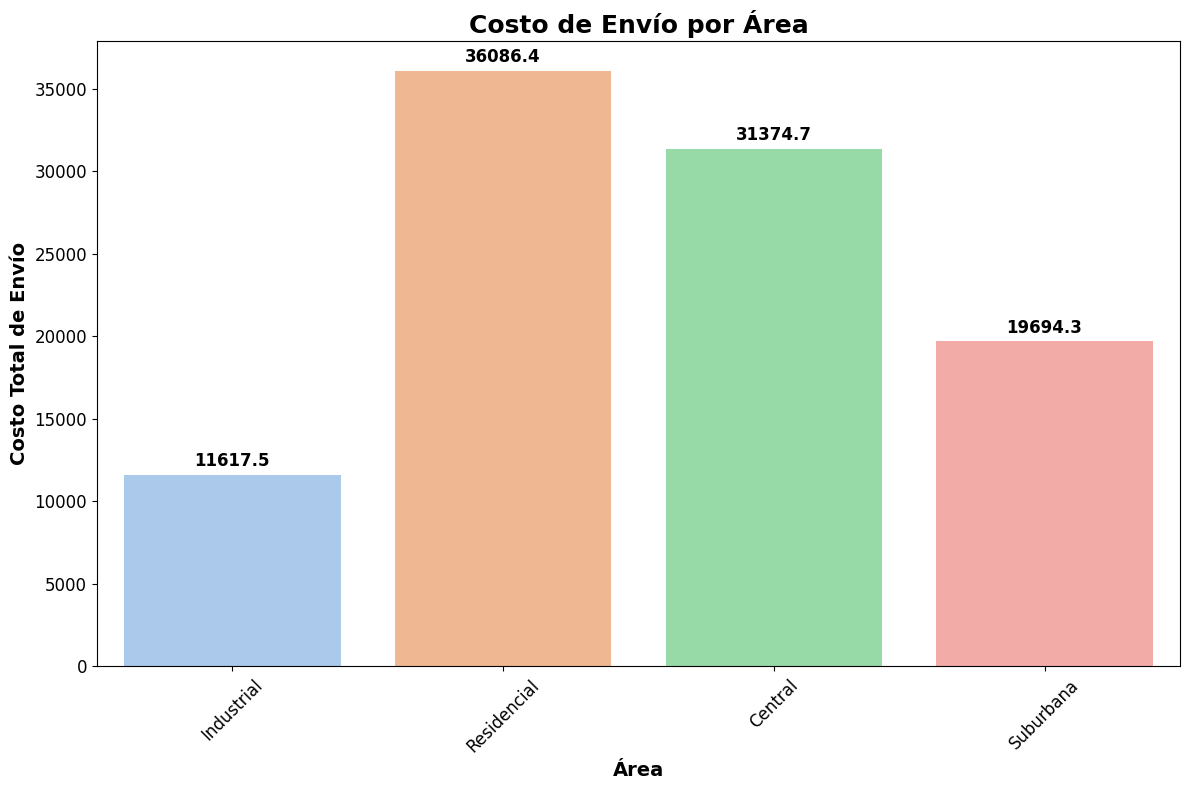

In [29]:
plt.figure(figsize=(12, 8))
barplot = sns.barplot(x='Area', y='Costo Envio', data=df_envio, estimator=sum, ci=None, palette="pastel")
plt.title('Costo de Envío por Área', fontsize=18, fontweight='bold')
plt.xlabel('Área', fontsize=14, fontweight='bold')
plt.ylabel('Costo Total de Envío', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Añadir valores en la parte superior de las barras
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.1f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 10),
                     textcoords = 'offset points',
                     fontsize=12,
                     color='black',
                     fontweight='bold')
    
plt.show()

$$
Informe
$$

1. **Eje x:** El eje x del gráfico muestra las cuatro áreas a las que se envía: Central, Industrial, Residencial y Suburbana.

2. **Eje y:** El eje y del gráfico muestra el costo total de envío en dólares estadounidenses.

3. **Barras:** La altura de cada barra representa el costo total de envío para cada área. Las barras están ordenadas de mayor a menor costo, comenzando con "Central" en la parte superior y "Suburbana" en la parte inferior. 

$$
Observaciones
$$

- El área Central tiene el costo de envío más alto, con un valor de **$36,086.40**.
- El área Industrial tiene el segundo costo de envío más alto, con un valor de **$31,374.70**.
- El área Residencial tiene el tercer costo de envío más alto, con un valor de **$19,694.30**.
- El área Suburbana tiene el costo de envío más bajo, con un valor de **$11,617.50**.
- La diferencia en el costo de envío entre las áreas es significativa. El área Central tiene un costo de envío que es casi tres veces mayor que el área Suburbana.

5. __Visualizacion gráficos de pastel de la distribución de pago__

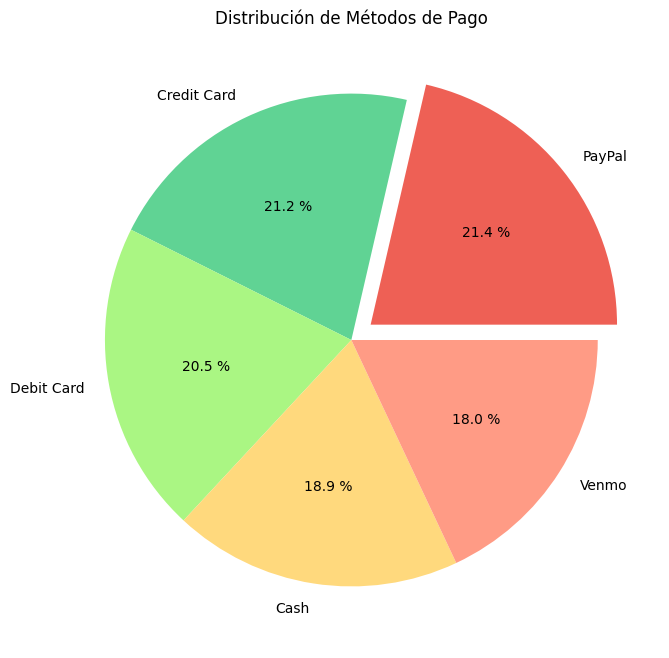

In [30]:
# Establecer el desfase para el gráfico de pastel
desfase = (0.1, 0, 0, 0, 0) 
plt.figure(figsize=(8, 8))
colores = ["#EE6055","#60D394","#AAF683","#FFD97D","#FF9B85"]
df_envio['Metodo de Pago'].value_counts().plot.pie(autopct='%0.1f %%', explode=desfase, colors = colores)
plt.title('Distribución de Métodos de Pago')
plt.ylabel('')  # Eliminar el título del eje y
plt.show()

$$
Informe
$$

El gráfico está dividido en cinco sectores, cada uno de los cuales representa un método de pago diferente. Los sectores están codificados por colores y llevan etiquetas que indican el nombre del método de pago y el porcentaje de usuarios que lo utilizan.

$$
Análisis
$$

El gráfico muestra que los métodos de pago más populares son las tarjetas de crédito (21,2%), las tarjetas de débito (20,5%), PayPal (21,4%) y el efectivo (18,9%). Venmo, un servicio de pago móvil, representa solo el 18,0% de los usuarios.

$$
Conclusiones
$$

El gráfico muestra que los métodos de pago tradicionales, como las tarjetas de crédito y débito, siguen siendo los más populares. Sin embargo, los métodos de pago digitales, como PayPal y Venmo, están ganando popularidad, especialmente entre los jóvenes.

> # Etapa 2: Ajuste de tipo de variables

1. __Tipos de datos__

In [31]:
df_envio.dtypes

Cliente                        object
Puntos de Fidelidad             int64
Codigo Postal                   int64
Empresa Envio                  object
Metodo Envio                   object
Area                           object
Costo Envio                   float64
Fecha Envio            datetime64[ns]
Fecha Entrega          datetime64[ns]
Fecha Pedido           datetime64[ns]
Producto                       object
Precio Unitario               float64
Cantidad                        int64
Metodo de Pago                 object
Oferta                         object
Descuento                     float64
Costo Final                   float64
dtype: object

1. Manejo de Fechas:

- Extraer componentes de fecha como día, mes, año, etc. solo para las columnas de interés


In [32]:
Order = df_envio.copy()
Order['Fecha Pedido'] = pd.to_datetime(Order['Fecha Pedido'])
Order['dia'] = Order['Fecha Pedido'].dt.day
Order['mes'] = Order['Fecha Pedido'].dt.month
Order['año'] = Order['Fecha Pedido'].dt.year

# Mostrar el DataFrame resultante
Order[['Cliente', 'Producto', 'Fecha Pedido', 'dia', 'mes', 'año']].head(5)

,Cliente,Producto,Fecha Pedido,dia,mes,año
EnviosID,,,,,,
1,Margalit Dacres,smartphone,2023-01-27,27,1,2023
2,Marietta Endicott,portable charger,2023-07-20,20,7,2023
3,Hailee Grimestone,smart home device,2023-04-05,5,4,2023
4,Asher McGougan,laptop,2023-06-17,17,6,2023
5,Margalit Penke,portable charger,2023-03-29,29,3,2023


- Cálculo de fechas

    Dias Transcurridos desde el envio hasta la fecha de entrega

In [33]:
shipment =  df_envio.copy()
shipment['Dias Transcurridos desde el envio'] = (shipment['Fecha Entrega'] - shipment['Fecha Envio']).dt.days
shipment['Dias Transcurridos desde el envio'] = shipment['Dias Transcurridos desde el envio'].abs() # Las fechas son generadas asi que suponemos que no todas las fechas llevan una secuencia
shipment[['Cliente', 'Producto', 'Cantidad', 'Fecha Entrega', 'Fecha Envio', 'Dias Transcurridos desde el envio']].head(6)


,Cliente,Producto,Cantidad,Fecha Entrega,Fecha Envio,Dias Transcurridos desde el envio
EnviosID,,,,,,
1,Margalit Dacres,smartphone,31,2023-06-28,2023-07-28,30
2,Marietta Endicott,portable charger,12,2023-07-16,2023-06-21,25
3,Hailee Grimestone,smart home device,8,2023-02-10,2023-05-15,94
4,Asher McGougan,laptop,24,2023-03-08,2023-12-24,291
5,Margalit Penke,portable charger,45,2023-06-01,2023-03-07,86
6,Agneta Woof,headphones,27,2023-07-23,2023-08-19,27


2.  __Manejo de Categorías__:

In [34]:
df_envio['Area'] = df_envio['Area'].astype('category')
df_envio['Producto'] = df_envio['Producto'].astype('category')  
df_envio['Metodo de Pago'] = df_envio['Metodo de Pago'].astype('category') 
df_envio['Oferta'] = df_envio['Oferta'].astype('category') 

Las categorías que se han definido en el DataFrame `df_envio` tienen un significado específico y se utilizan para clasificar los datos de manera ordenada y eficiente. Aquí está el informe sobre el significado de estas categorías:

1. **Area:** Esta categoría representa las diferentes áreas o regiones a las que se envían los productos. En este caso, se han identificado cuatro áreas distintas donde se realizan los envíos.

2. **Producto:** Esta categoría se refiere a los distintos tipos de productos que se envían. El DataFrame actualmente contiene información sobre diez productos diferentes que pueden estar siendo enviados.

3. **Método de Pago:** Esta categoría indica los diferentes métodos utilizados para realizar el pago de los productos. El DataFrame registra cinco métodos de pago diferentes que pueden estar asociados a los envíos.

4. **Oferta:** Aquí se registran las diferentes ofertas o promociones aplicadas a los envíos. El DataFrame muestra información sobre cuatro ofertas específicas que pueden haber sido utilizadas en los envíos.

Estas categorías son útiles para organizar y analizar los datos de envíos de manera más precisa y para realizar análisis posteriores sobre patrones de compra, preferencias de pago, efectividad de ofertas, entre otros aspectos relevantes para la gestión de envíos y ventas.

In [35]:
df_envio.dtypes

Cliente                        object
Puntos de Fidelidad             int64
Codigo Postal                   int64
Empresa Envio                  object
Metodo Envio                   object
Area                         category
Costo Envio                   float64
Fecha Envio            datetime64[ns]
Fecha Entrega          datetime64[ns]
Fecha Pedido           datetime64[ns]
Producto                     category
Precio Unitario               float64
Cantidad                        int64
Metodo de Pago               category
Oferta                       category
Descuento                     float64
Costo Final                   float64
dtype: object

> # Etapa 3: Detección y tratamientos de datos ausentes:

- Comprobar valores nulos


In [36]:
df_envio.isna().sum()

Cliente                0
Puntos de Fidelidad    0
Codigo Postal          0
Empresa Envio          0
Metodo Envio           0
Area                   0
Costo Envio            0
Fecha Envio            0
Fecha Entrega          0
Fecha Pedido           0
Producto               0
Precio Unitario        0
Cantidad               0
Metodo de Pago         0
Oferta                 0
Descuento              0
Costo Final            0
dtype: int64

## Si bien no se observan valores nulos en el conjunto de datos, se procederá a utilizar el método dropna() para eliminar filas con valores faltantes en cualquier columna.

In [37]:
df_envio = df_envio.dropna()

> # Etapa 4: Identificación y tratamiento de datos atípicos:

1. __Histograma__

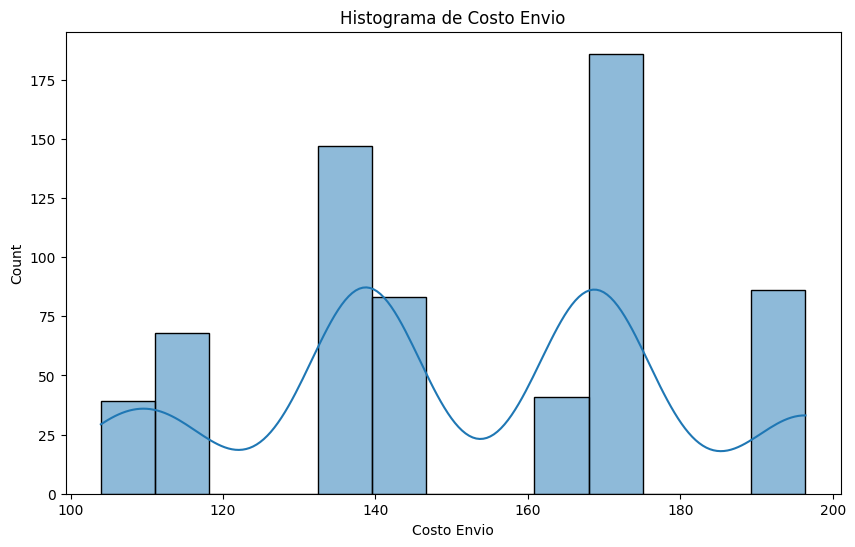

In [38]:
plt.figure(figsize=(10, 6))
sns.histplot(df_envio['Costo Envio'], kde=True)
plt.title('Histograma de Costo Envio')
plt.show()

El histograma muestra la distribución del "Costo Envío" con una línea de densidad superpuesta. Aquí hay algunas deducciones que podemos hacer a partir del gráfico:

1. **Distribución Multimodal**: La distribución del costo de envío parece tener múltiples picos, lo que sugiere que hay varias subpoblaciones o grupos dentro de los datos.

2. **Variabilidad del Costo**: Hay una variabilidad significativa en los costos de envío, que oscilan entre aproximadamente 100 y 200 unidades monetarias.

3. **Picos Principales**: Hay picos significativos alrededor de los 120, 140 y 180 unidades monetarias, indicando que estos valores son comunes o populares entre los datos.

4. **Frecuencias**: La mayor frecuencia de costos de envío se encuentra alrededor de los 140 y 180 unidades monetarias, con más de 150 ocurrencias cada uno.

5. **Tendencia General**: La línea de densidad muestra que hay fluctuaciones notables en la frecuencia de los costos de envío, lo que podría indicar variaciones estacionales, diferencias regionales o estrategias de precios diferenciadas.

2. __BoxPlot__

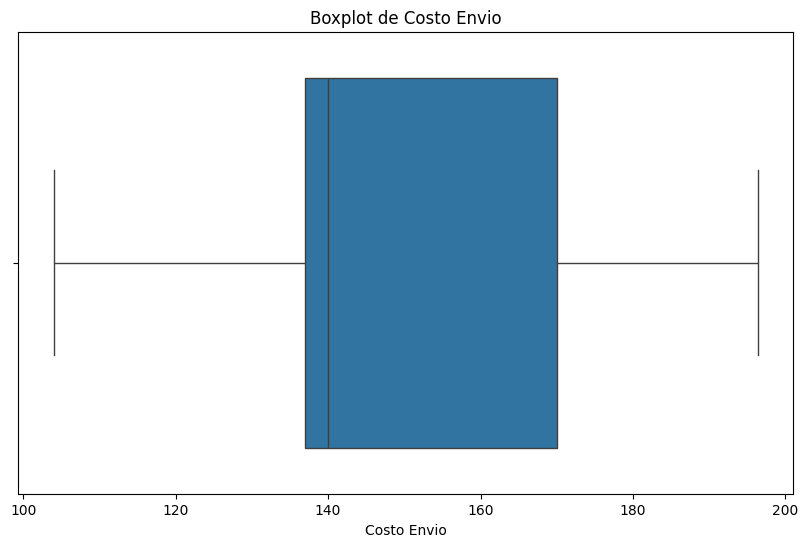

In [39]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_envio['Costo Envio'])
plt.title('Boxplot de Costo Envio')
plt.show()

El boxplot del "Costo Envío" proporciona una visión más detallada de la distribución de los datos, incluyendo la mediana, los cuartiles y los valores atípicos. Aquí hay algunas deducciones basadas en el boxplot:

1. **Mediana**: La línea dentro de la caja representa la mediana del costo de envío, que parece estar alrededor de los 140 unidades monetarias.

2. **Rango Intercuartílico (IQR)**: La caja abarca desde el primer cuartil (Q1) hasta el tercer cuartil (Q3), que representan el 25% y el 75% de los datos, respectivamente. El IQR parece estar entre aproximadamente 130 y 170 unidades monetarias.

3. **Rango Total**: Las líneas que se extienden desde la caja (bigotes) muestran la extensión de los datos sin considerar los valores atípicos. El rango total parece ser de aproximadamente 100 a 200 unidades monetarias.

4. **Simetría**: La mediana está un poco más cerca del primer cuartil, lo que sugiere una ligera asimetría hacia la derecha en la distribución del costo de envío.

5. **Valores Atípicos**: No hay valores atípicos visibles en el boxplot, lo que indica que los datos no tienen puntos de datos extremadamente alejados del resto.


3. __Z-Score__

In [40]:
outliers = df_envio.copy()
outliers['Z-score'] = np.abs(stats.zscore(df_envio['Costo Envio']))
outliers_zscore = outliers[outliers['Z-score'] > 3]
print("Outliers basandos en Z-score:")
print(outliers_zscore)

Outliers basandos en Z-score:
Empty DataFrame
Columns: [Cliente, Puntos de Fidelidad, Codigo Postal, Empresa Envio, Metodo Envio, Area, Costo Envio, Fecha Envio, Fecha Entrega, Fecha Pedido, Producto, Precio Unitario, Cantidad, Metodo de Pago, Oferta, Descuento, Costo Final, Z-score]
Index: []


4. __Z-Score modificado__

In [41]:
def modified_zscore(series):
    median = np.median(series)
    mad = np.median(np.abs(series - median))
    return 0.6745 * (series - median) / mad

outliers['Modified Z-score'] = modified_zscore(outliers['Costo Envio'])
outliers_modified_zscore = outliers[outliers['Modified Z-score'] > 3.5]
print("Outliers basandos en Modified Z-score:")
print(outliers_modified_zscore)

Outliers basandos en Modified Z-score:
Empty DataFrame
Columns: [Cliente, Puntos de Fidelidad, Codigo Postal, Empresa Envio, Metodo Envio, Area, Costo Envio, Fecha Envio, Fecha Entrega, Fecha Pedido, Producto, Precio Unitario, Cantidad, Metodo de Pago, Oferta, Descuento, Costo Final, Z-score, Modified Z-score]
Index: []


- Presentación de los outliers

In [42]:
outliers[['Cliente', 'Producto', 'Cantidad', "Costo Envio",'Z-score', 'Modified Z-score']].head(10)

,Cliente,Producto,Cantidad,Costo Envio,Z-score,Modified Z-score
EnviosID,,,,,,
1,Margalit Dacres,smartphone,31,139.97,0.444584,0.000000
2,Marietta Endicott,portable charger,12,139.97,0.444584,0.000000
3,Hailee Grimestone,smart home device,8,136.95,0.556579,-0.072984
4,Asher McGougan,laptop,24,112.06,1.479617,-0.674500
5,Margalit Penke,portable charger,45,139.97,0.444584,0.000000
6,Agneta Woof,headphones,27,168.06,0.597125,0.678850
7,Allen Capron,laptop,0,196.41,1.648475,1.363984
8,Nolie Heaviside,smartphone,42,168.06,0.597125,0.678850
9,Karna Borman,virtual reality headset,21,138.82,0.487231,-0.027792


## Análisis de las primeras 10 filas del dataset, centrándose en la columna "Costo Envio" y los puntajes Z (Z-score y Modified Z-score):

**Análisis del Costo de Envío:**

1. **Valores Comunes de Costo Envio**:
   - Los costos de envío de 139.97 y 138.82 son comunes y tienen puntajes Z que indican que están cerca de la media del conjunto de datos.
   - Los costos de envío de 168.06 y 196.41 son más altos, lo que se refleja en sus puntajes Z más altos.

2. **Z-score**:
   - Un Z-score positivo sugiere que el costo de envío es mayor que la media, mientras que un Z-score negativo indica que es menor que la media.
   - Por ejemplo, el costo de 112.06 tiene el Z-score más alto de 1.479617, indicando que está significativamente por debajo de la media.
   - El costo de 196.41 tiene el Z-score más alto de 1.648475, indicando que es considerablemente mayor que la media.

3. **Modified Z-score**:
   - Utilizado para detectar valores atípicos de manera más robusta.
   - Un Modified Z-score mayor que 3.5 o menor que -3.5 suele indicar un valor atípico.
   - En este caso, los costos de envío de 168.06 y 196.41 tienen Modified Z-scores positivos significativos (0.678850 y 1.363984), sugiriendo que estos son valores atípicos altos en comparación con el resto del conjunto de datos.

**Conclusiones:**

1. **Costo Envio Consistente**: La mayoría de los costos de envío (139.97 y 138.82) están alrededor de la media, lo que sugiere una política de precios estándar.
   
2. **Valores Atípicos**: 
   - El costo de 112.06 se destaca como un valor atípico bajo con un Z-score de 1.479617 y un Modified Z-score de -0.674500.
   - Los costos de 168.06 y 196.41 se destacan como valores atípicos altos con Z-scores de 0.597125 y 1.648475, y Modified Z-scores de 0.678850 y 1.363984 respectivamente.
   
3. **Simetría y Dispersión**: La dispersión de los costos de envío y la presencia de varios valores atípicos altos sugiere una distribución algo asimétrica hacia la derecha (más valores altos que bajos).

5. __Rango intercuartílico__

In [43]:
Q1 = df_envio['Costo Envio'].quantile(0.25)
Q3 = df_envio['Costo Envio'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Q1: {Q1}")
print(f"Q3: {Q3}")
print(f"IQR: {IQR}")
print(f"Lower Bound: {lower_bound}")
print(f"Upper Bound: {upper_bound}")

outliers_iqr = df_envio[(df_envio['Costo Envio'] < lower_bound) | (df_envio['Costo Envio'] > upper_bound)]
print("Outliers basados en IQR:")
outliers_iqr

Q1: 136.95
Q3: 169.99
IQR: 33.04000000000002
Lower Bound: 87.38999999999996
Upper Bound: 219.55000000000004
Outliers basados en IQR:


,Cliente,Puntos de Fidelidad,Codigo Postal,Empresa Envio,Metodo Envio,Area,Costo Envio,Fecha Envio,Fecha Entrega,Fecha Pedido,Producto,Precio Unitario,Cantidad,Metodo de Pago,Oferta,Descuento,Costo Final
EnviosID,,,,,,,,,,,,,,,,,


Desglose de la información proporcionada de valores atípicos en la columna 'Costo Envio' según el método del Rango Intercuartílico (IQR):

1. **Cuartiles:**
   - **Q1 (Primer Cuartil):** 136.95
   - **Q3 (Tercer Cuartil):** 169.99

2. **Rango Intercuartílico (IQR):**
   - IQR = Q3 - Q1 = 169.99 - 136.95 = 33.04

3. **Límites para Valores Atípicos:**
   - **Límite Inferior:** Q1 - 1.5 * IQR = 136.95 - 1.5 * 33.04 = 87.39
   - **Límite Superior:** Q3 + 1.5 * IQR = 169.99 + 1.5 * 33.04 = 219.55

4. **Valores Atípicos:**
   - Valores por debajo de 87.39 o por encima de 219.55 se consideran atípicos.
   - Mencionaste que no hay filas identificadas como valores atípicos.

### __Interpretación__ 

Dado que no se identificaron valores atípicos basados en el método del IQR para la columna 'Costo Envio', puedes concluir que la distribución de los valores de 'Costo Envio' es relativamente normal dentro de los límites definidos. Esto indica que todos los valores se encuentran dentro del rango esperado sin desviaciones extremas.

> # Etapa 5: Correlación de variables:

### 1.  __Correlación entre la categoría del producto y la región de venta (area)__

In [44]:
contingency_table = pd.crosstab(df_envio['Producto'], df_envio['Area'])

# Realizar la prueba de chi-cuadrado
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Mostrar los resultados de la prueba de chi-cuadrado
print("Tabla de Contingencia:")
contingency_table

Tabla de Contingencia:


Area,Central,Industrial,Residencial,Suburbana
Producto,,,,
headphones,22,9,26,21
laptop,56,19,44,29
portable charger,15,10,37,15
smart home device,24,9,19,18
smartphone,49,21,60,26
virtual reality headset,29,15,55,22



Resultados de la prueba de Chi-cuadrado:
Chi-cuadrado: 21.370477680456652
p-valor: 0.12540417604657828
Grados de libertad: 15


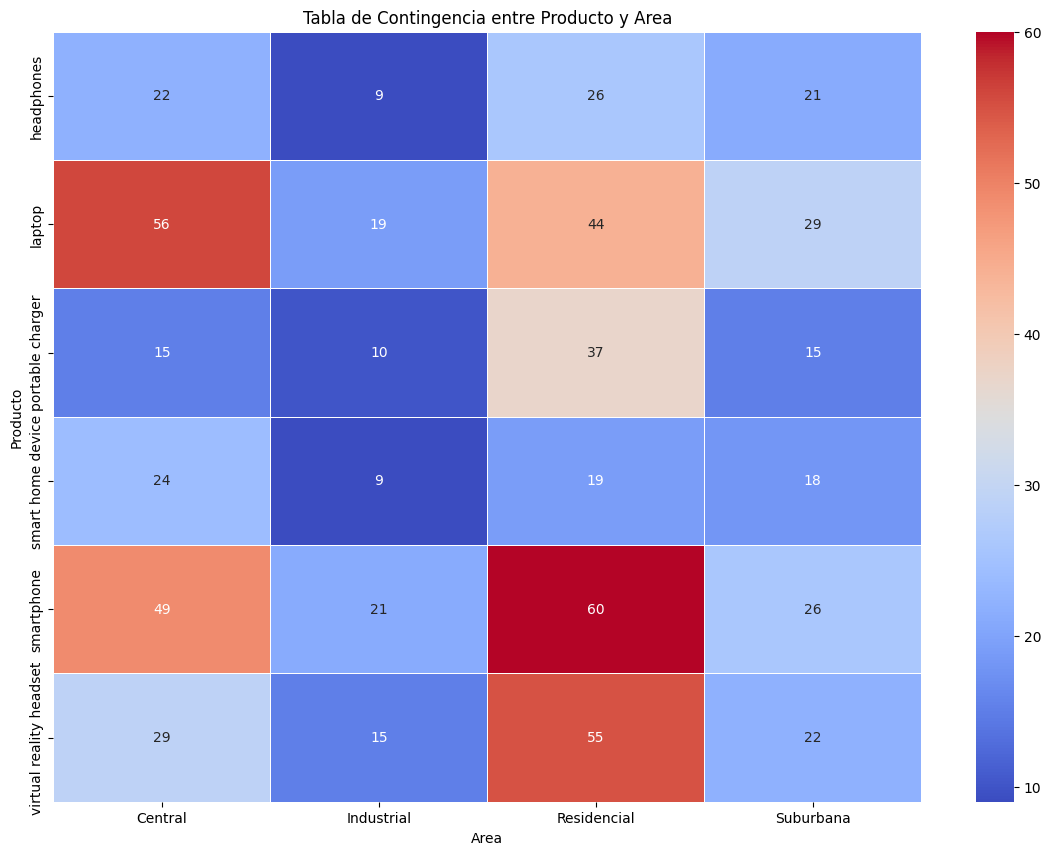

In [45]:
print("\nResultados de la prueba de Chi-cuadrado:")
print(f"Chi-cuadrado: {chi2}")
print(f"p-valor: {p}")
print(f"Grados de libertad: {dof}")
# Visualizar la tabla de contingencia usando un mapa de calor
plt.figure(figsize=(14, 10))
sns.heatmap(contingency_table, annot=True, cmap='coolwarm', linewidths=0.5, fmt='d')
plt.title('Tabla de Contingencia entre Producto y Area')
plt.show()

**Informe de Análisis de Ventas por Producto y Región**

---

**Resumen**

El análisis realizado se centra en determinar la relación entre la categoría del producto y la región de venta (área) en función de los datos recopilados. Se empleó la prueba de Chi-cuadrado para evaluar la significancia estadística de esta relación. Además, se generó un heatmap que muestra la cantidad de productos vendidos en diferentes regiones, proporcionando información valiosa sobre la distribución de ventas, patrones de consumo, comparaciones entre productos y posibles oportunidades de mercado.

---

**Resultados del Análisis Estadístico**

1. **Prueba de Chi-cuadrado:**
   - Valor de Chi-cuadrado: 21.3705
   - P-valor: 0.1254
   - Grados de libertad: 15

El p-valor obtenido (0.1254) es mayor que el nivel de significancia estándar de 0.05, lo que sugiere que no hay suficiente evidencia para rechazar la hipótesis nula. En consecuencia, no se encuentra una relación estadísticamente significativa entre la categoría del producto y la región de venta en los datos analizados.

---

**Análisis del Heatmap**

1. **Distribución de Ventas por Producto y Área:**
   - El heatmap muestra cómo se distribuyen las ventas de cada producto en diferentes regiones, revelando posibles disparidades en las preferencias de compra según el área.

2. **Patrones de Consumo por Región:**
   - Se identifican patrones de consumo que podrían reflejar las preferencias de los clientes en cada región. Por ejemplo, se observa si ciertos productos tienen una demanda más alta en áreas específicas.

3. **Comparación entre Productos:**
   - Al contrastar las cantidades vendidas de diferentes productos en cada área, se pueden discernir tendencias de mercado que indican diferencias en la demanda o perfiles de consumidores según el entorno.

4. **Oportunidades de Mercado:**
   - Los datos revelan posibles oportunidades de mercado, como productos con baja venta pero alto interés en ciertas áreas, sugiriendo áreas de mejora en estrategias de marketing y distribución.

---

**Conclusiones y Recomendaciones**

En conclusión, el análisis indica que no existe una relación significativa entre la categoría del producto y la región de venta en el conjunto de datos analizados. No obstante, el heatmap proporciona información valiosa para comprender cómo varían las ventas de productos en diferentes áreas, lo que puede guiar decisiones estratégicas en términos de marketing, distribución y desarrollo de productos.

> # Etapa 6: Visualización de datos :

- Definir eda

In [46]:
columns = [col for col in df_envio.columns if col != 'Codigo Postal'] # "El Código Postal es numérico, pero no es utilizable para análisis estadísticos. 
df_filterd = df_envio[columns]  
eda = edaSQL.EDA(dataFrame=df_filterd, HTMLDisplay=True)

### 1. __Analisis univariado__

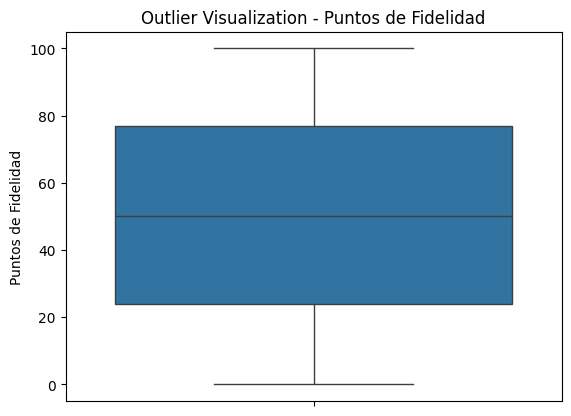

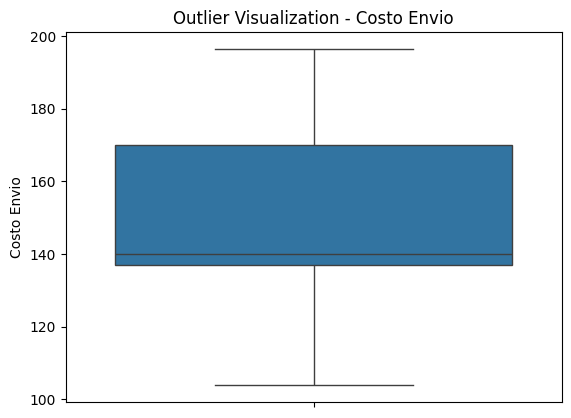

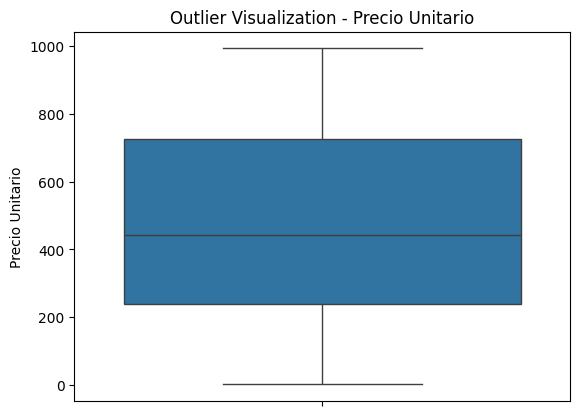

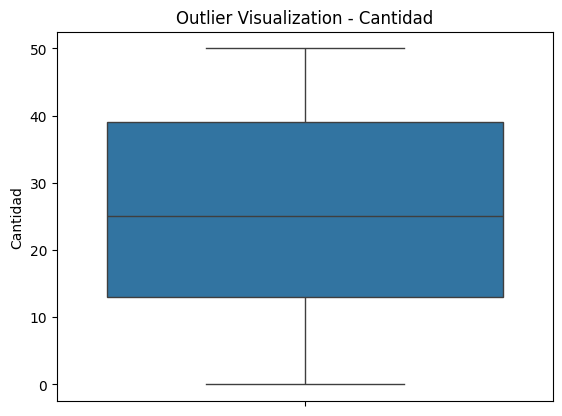

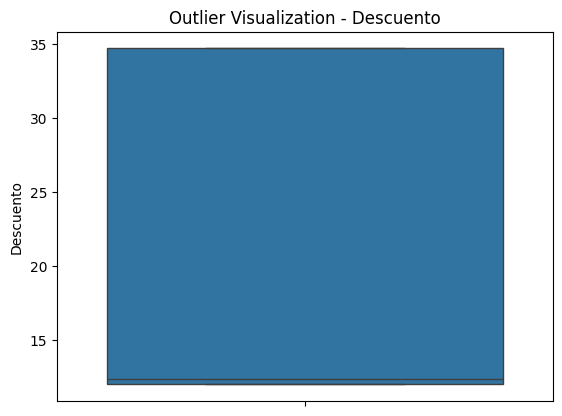

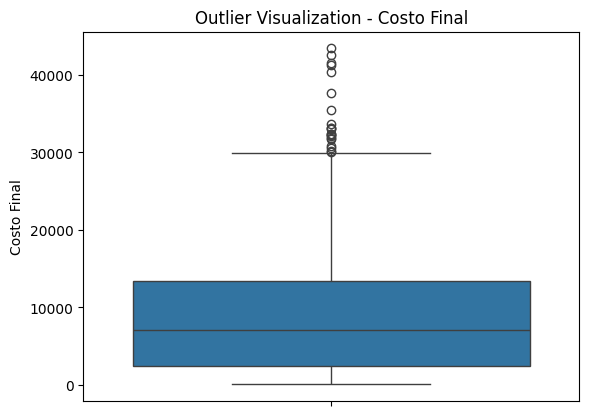

In [47]:
eda.outliersVisualization(plot="box")

## Análisis de la visualización de valores atípicos 

Las visualizaciónes constan de un diagrama de caja, que es un tipo de gráfico que muestra la distribución de un conjunto de datos. El cuadro en el diagrama de cajas representa el rango intercuartílico (IQR), que es el 50% medio de los datos. Los bigotes en los extremos del cuadro representan el rango de los datos, excluyendo los valores atípicos. Los valores atípicos son puntos de datos que están a más de 1,5 veces el IQR del cuadro.

### 1.  __Puntos de Fidelidad__

En este caso, hay algunos valores atípicos en el conjunto de datos. Estos valores atípicos se encuentran en la parte superior del diagrama de cajas, lo que indica que son valores altos. Esto sugiere que hay un pequeño número de clientes que tienen un número muy alto de puntos de fidelidad. Es posible que estos clientes sean muy leales a la empresa y hayan estado realizando compras durante mucho tiempo. También es posible que hayan realizado una gran cantidad de compras en un corto período de tiempo, quizás debido a una promoción u oferta especial.

Valores atípicos:

* La mediana del número de puntos de fidelidad es de aproximadamente 20.
* La distribución de los puntos de fidelidad está sesgada hacia la derecha, lo que significa que hay más clientes con un número bajo de puntos de fidelidad que clientes con un número alto de puntos de fidelidad.
* Los valores atípicos no están muy lejos del cuadro, lo que sugiere que no son valores extremos.

### 2. __Costo de envio__

Valores atípicos:

- *Mediana*: La línea dentro de la caja representa la mediana del costo de envío, que parece estar un poco por debajo de 150.

- *Cuartiles*:
   - El borde inferior de la caja representa el primer cuartil (Q1), que está alrededor de 140.
   - El borde superior de la caja representa el tercer cuartil (Q3), que está cerca de 160.

- *Rango intercuartil (IQR)*: La diferencia entre Q3 y Q1, que sería aproximadamente 160 - 140 = 20. Esto indica la dispersión del 50% central de los datos.

- *Rangos*:
   - Los "bigotes" se extienden desde los cuartiles hasta los valores mínimos y máximos dentro de 1.5 veces el IQR. Aquí, el bigote inferior llega a 100 y el superior a 200.

- *Outliers*: No parece haber puntos fuera de los bigotes, lo que sugiere que no hay valores atípicos (outliers) en los datos del costo de envío según esta visualización.

En resumen, el box plot muestra que la mayoría de los costos de envío se sitúan entre 140 y 160, con valores que pueden oscilar entre 100 y 200 sin ningún outlier visible.

 ### 3. __Precio unitario__

A continuación, se deducen algunas observaciones:

- *Mediana*: La línea dentro de la caja representa la mediana del precio unitario, que parece estar alrededor de 500.

-  *Cuartiles*:
   - El borde inferior de la caja representa el primer cuartil (Q1), que está alrededor de 400.
   - El borde superior de la caja representa el tercer cuartil (Q3), que está cerca de 600.

-  *Rango intercuartil (IQR)*: La diferencia entre Q3 y Q1 es aproximadamente 600 - 400 = 200. Esto indica la dispersión del 50% central de los datos del precio unitario.

-  *Rangos*:
   - Los "bigotes" se extienden desde los cuartiles hasta los valores mínimos y máximos dentro de 1.5 veces el IQR. Aquí, el bigote inferior llega a 0 y el superior a 1000.

-  *Outliers*: No parece haber puntos fuera de los bigotes, lo que sugiere que no hay valores atípicos (outliers) en los datos del precio unitario según esta visualización.

En resumen, el box plot muestra que la mayoría de los precios unitarios se sitúan entre 400 y 600, con valores que pueden oscilar entre 0 y 1000 sin ningún outlier visible.

### 4.  __Cantidad__

Visualizacion de  la distribución de la "Cantidad". Aquí están algunas deducciones que se pueden hacer:

- *Mediana*: La línea dentro de la caja representa la mediana de la cantidad, que parece estar alrededor de 25.

- *Cuartiles*:
   - El borde inferior de la caja representa el primer cuartil (Q1), que está alrededor de 20.
   - El borde superior de la caja representa el tercer cuartil (Q3), que está cerca de 35.

- *Rango intercuartil (IQR)*: La diferencia entre Q3 y Q1 es aproximadamente 35 - 20 = 15. Esto indica la dispersión del 50% central de los datos de la cantidad.

- *Rangos*:
   - Los "bigotes" se extienden desde los cuartiles hasta los valores mínimos y máximos dentro de 1.5 veces el IQR. Aquí, el bigote inferior llega a 0 y el superior a 50.

- *Outliers*: No parece haber puntos fuera de los bigotes, lo que sugiere que no hay valores atípicos (outliers) en los datos de la cantidad según esta visualización.

En resumen, el box plot muestra que la mayoría de las cantidades se sitúan entre 20 y 35, con valores que pueden oscilar entre 0 y 50 sin ningún outlier visible.

### 5.  __Descuento__

De la gráfica, se pueden deducir las siguientes cosas:

- *Ausencia de valores atípicos (outliers)*: En esta gráfica de caja no se observan puntos individuales que se salgan del rango del "bigote" superior e inferior, lo que indica que no hay valores atípicos significativos en los datos de "Descuento".

- *Distribución de los datos*: La caja en la gráfica representa el rango intercuartil (IQR), que abarca desde el primer cuartil (Q1) hasta el tercer cuartil (Q3). La línea en el interior de la caja indica la mediana (Q2) de los datos. En este caso, parece que la caja ocupa una porción significativa de la escala vertical, lo que sugiere una distribución relativamente uniforme o equilibrada de los valores de "Descuento".

- *Rango de valores*: Los "bigotes" de la caja indican el rango de los datos que no son considerados atípicos. En esta gráfica, los "bigotes" abarcan desde aproximadamente 15 hasta 35, lo que sugiere que todos los valores de "Descuento" están dentro de este rango.

En resumen, la gráfica sugiere que los datos de "Descuento" no tienen valores atípicos y están distribuidos de manera uniforme dentro del rango de 15 a 35.

### 6.  __Costo Final__

La imagen es un diagrama de caja (boxplot) que visualiza la distribución de la variable "Costo Final". Aquí tienes un análisis de este diagrama:

1. *Mediana (Q2)*: La línea horizontal dentro de la caja representa el valor mediano del "Costo Final". Parece estar alrededor de 10,000.

2. *Rango Intercuartílico (IQR)*: La caja representa el rango intercuartílico, que contiene el 50% central de los datos. El límite inferior (Q1) está alrededor de 5,000 y el límite superior (Q3) está alrededor de 15,000.

3. *Bigotes*: Las líneas que se extienden desde la caja (bigotes) representan el rango de los datos excluyendo los valores atípicos. El bigote inferior llega cerca de 0 y el bigote superior se extiende hasta alrededor de 30,000.

4. *Valores Atípicos (Outliers)*: Los puntos por encima del bigote superior se consideran valores atípicos. Estos son valores que caen fuera de 1.5 veces el rango intercuartílico por encima de Q3. Hay varios valores atípicos con valores de "Costo Final" que superan los 30,000, con algunos alcanzando más de 40,000.

### Observaciones Clave:

- *Tendencia Central*: La mediana del "Costo Final" es aproximadamente 10,000.
- *Dispersión*: Hay una dispersión significativa en los valores del "Costo Final", con el rango intercuartílico que va de aproximadamente 5,000 a 15,000.
- *Valores Atípicos*: Hay muchos valores atípicos por encima del bigote superior, lo que indica algunos valores de "Costo Final" inusualmente altos.
- *Simetría*: El diagrama de caja sugiere una distribución sesgada a la derecha, ya que la mediana está más cerca del cuartil inferior y hay más valores atípicos en el extremo superior.


### 2. __Analsis Bivariado__

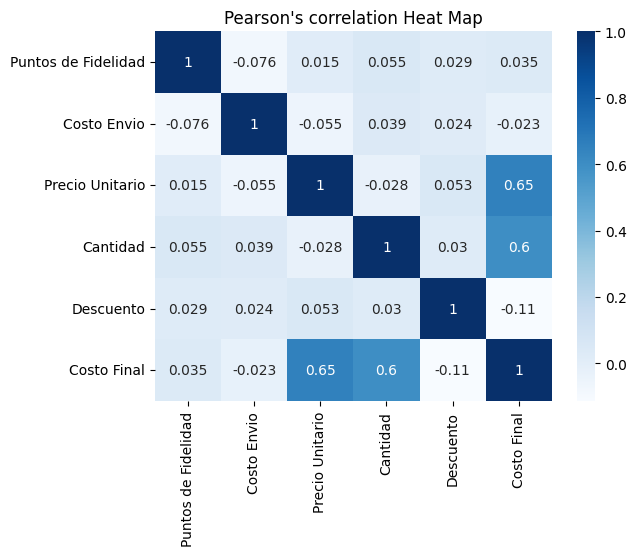

In [48]:
eda.pearsonCorrelation()


El gráfico proporcionado es un mapa de calor de la correlación de Pearson entre varias variables. Este tipo de gráfico se utiliza para mostrar visualmente las relaciones lineales entre las variables. Aquí están las deducciones que se pueden hacer:

- **Interpretación de la correlación de Pearson**:
   - Los valores van de -1 a 1.
   - 1 indica una correlación positiva perfecta.
   - -1 indica una correlación negativa perfecta.
   - 0 indica que no hay correlación lineal.

- **Observaciones de las correlaciones**:

   1. **Correlaciones Positivas Fuertes**:
      - Hay una fuerte correlación positiva entre el **Precio Unitario** y el **Costo Final**, con un coeficiente de correlación de 0.65. Esto indica que a medida que aumenta el precio unitario, el costo final tiende a aumentar.
      - De manera similar, la **Cantidad** también tiene una fuerte correlación positiva con el **Costo Final**, con un coeficiente de correlación de 0.60. Esto significa que a medida que aumenta la cantidad, el costo final tiende a aumentar.

   2. **Correlaciones Moderadas a Débiles**:
      - La **Cantidad** tiene una correlación negativa débil con el **Precio Unitario**, indicada por un coeficiente de -0.028. Esto sugiere que casi no hay relación entre la cantidad y el precio unitario.
      - Los **Puntos de Fidelidad** tienen correlaciones débiles con todas las otras variables, siendo la más alta 0.055 con la **Cantidad**.

   3. **Correlaciones Negligibles**:
      - El **Descuento** tiene una correlación negativa débil con el **Costo Final** (-0.11), lo que significa que el descuento disminuye ligeramente el costo final.
      - El **Costo Envío** tiene correlaciones muy débiles con todas las otras variables, siendo la más alta 0.039 con la **Cantidad**.

### Conclusiones
- El **costo final** está principalmente influenciado por el **precio unitario** y la **cantidad**.
- Los **descuentos** disminuyen ligeramente el costo final pero no tienen una influencia fuerte.
- Los **puntos de fidelidad**, los **costos de envío** y los **descuentos** tienen un impacto mínimo en el **costo final** en comparación con el **precio unitario** y la **cantidad**.
- No se observan correlaciones negativas fuertes entre las variables, lo que indica que los aumentos en una variable generalmente no resultan en disminuciones en otra en este conjunto de datos.

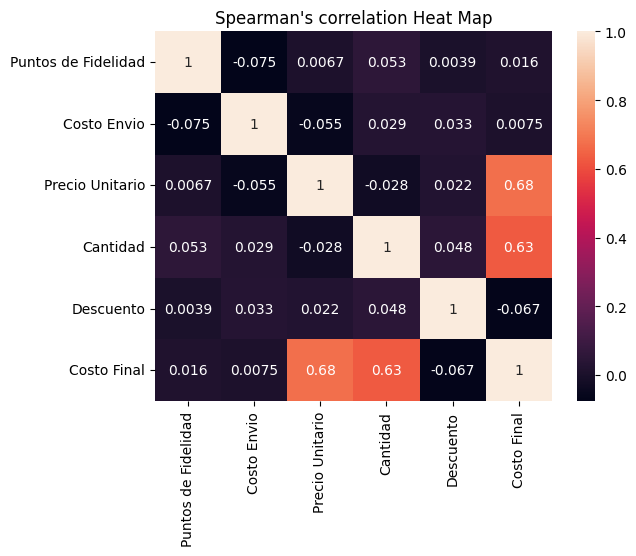

In [49]:
eda.spearmanCorrelation()


### Mapa de Calor de Correlación de Spearman: Observaciones y Conclusiones

#### 1. Correlaciones Positivas Fuertes:
   - **Precio Unitario y Costo Final**: 
     - Correlación: 0.68
     - Interpretación: A medida que aumenta el precio unitario, el costo final tiende a aumentar.
   - **Cantidad y Costo Final**: 
     - Correlación: 0.63
     - Interpretación: A medida que aumenta la cantidad, el costo final también tiende a aumentar.

#### 2. Correlaciones Moderadas a Débiles:
   - **Cantidad y Precio Unitario**: 
     - Correlación: -0.028
     - Interpretación: Existe muy poca relación entre la cantidad y el precio unitario.
   - **Puntos de Fidelidad y Cantidad**: 
     - Correlación: 0.053
     - Interpretación: Relación muy débil entre los puntos de fidelidad y la cantidad.

#### 3. Correlaciones Negligibles:
   - **Descuento y Costo Final**: 
     - Correlación: -0.067
     - Interpretación: El descuento disminuye ligeramente el costo final.
   - **Costo Envio y Descuento**: 
     - Correlación: 0.033
     - Interpretación: Relación muy débil entre el costo de envío y el descuento.

### Conclusiones Comparativas con el Mapa de Calor de Pearson

#### Similitudes:
- Ambos mapas muestran que el **Costo Final** está fuertemente influenciado por el **Precio Unitario** y la **Cantidad**.
- En ambos mapas, los **Descuentos** disminuyen ligeramente el costo final pero no tienen una influencia fuerte.
- **Puntos de Fidelidad**, **Costos de Envío** y **Descuentos** tienen un impacto mínimo en el **Costo Final** en comparación con el **Precio Unitario** y la **Cantidad**.
- No se observan correlaciones negativas fuertes entre las variables en ninguno de los dos mapas, indicando que los aumentos en una variable generalmente no resultan en disminuciones en otra en estos conjuntos de datos.

#### Diferencias:
- La metodología de Spearman es más robusta frente a relaciones no lineales y la presencia de valores atípicos, lo que puede proporcionar una visión ligeramente diferente de las correlaciones, aunque en este caso, los resultados generales son bastante consistentes con los del mapa de calor de Pearson.

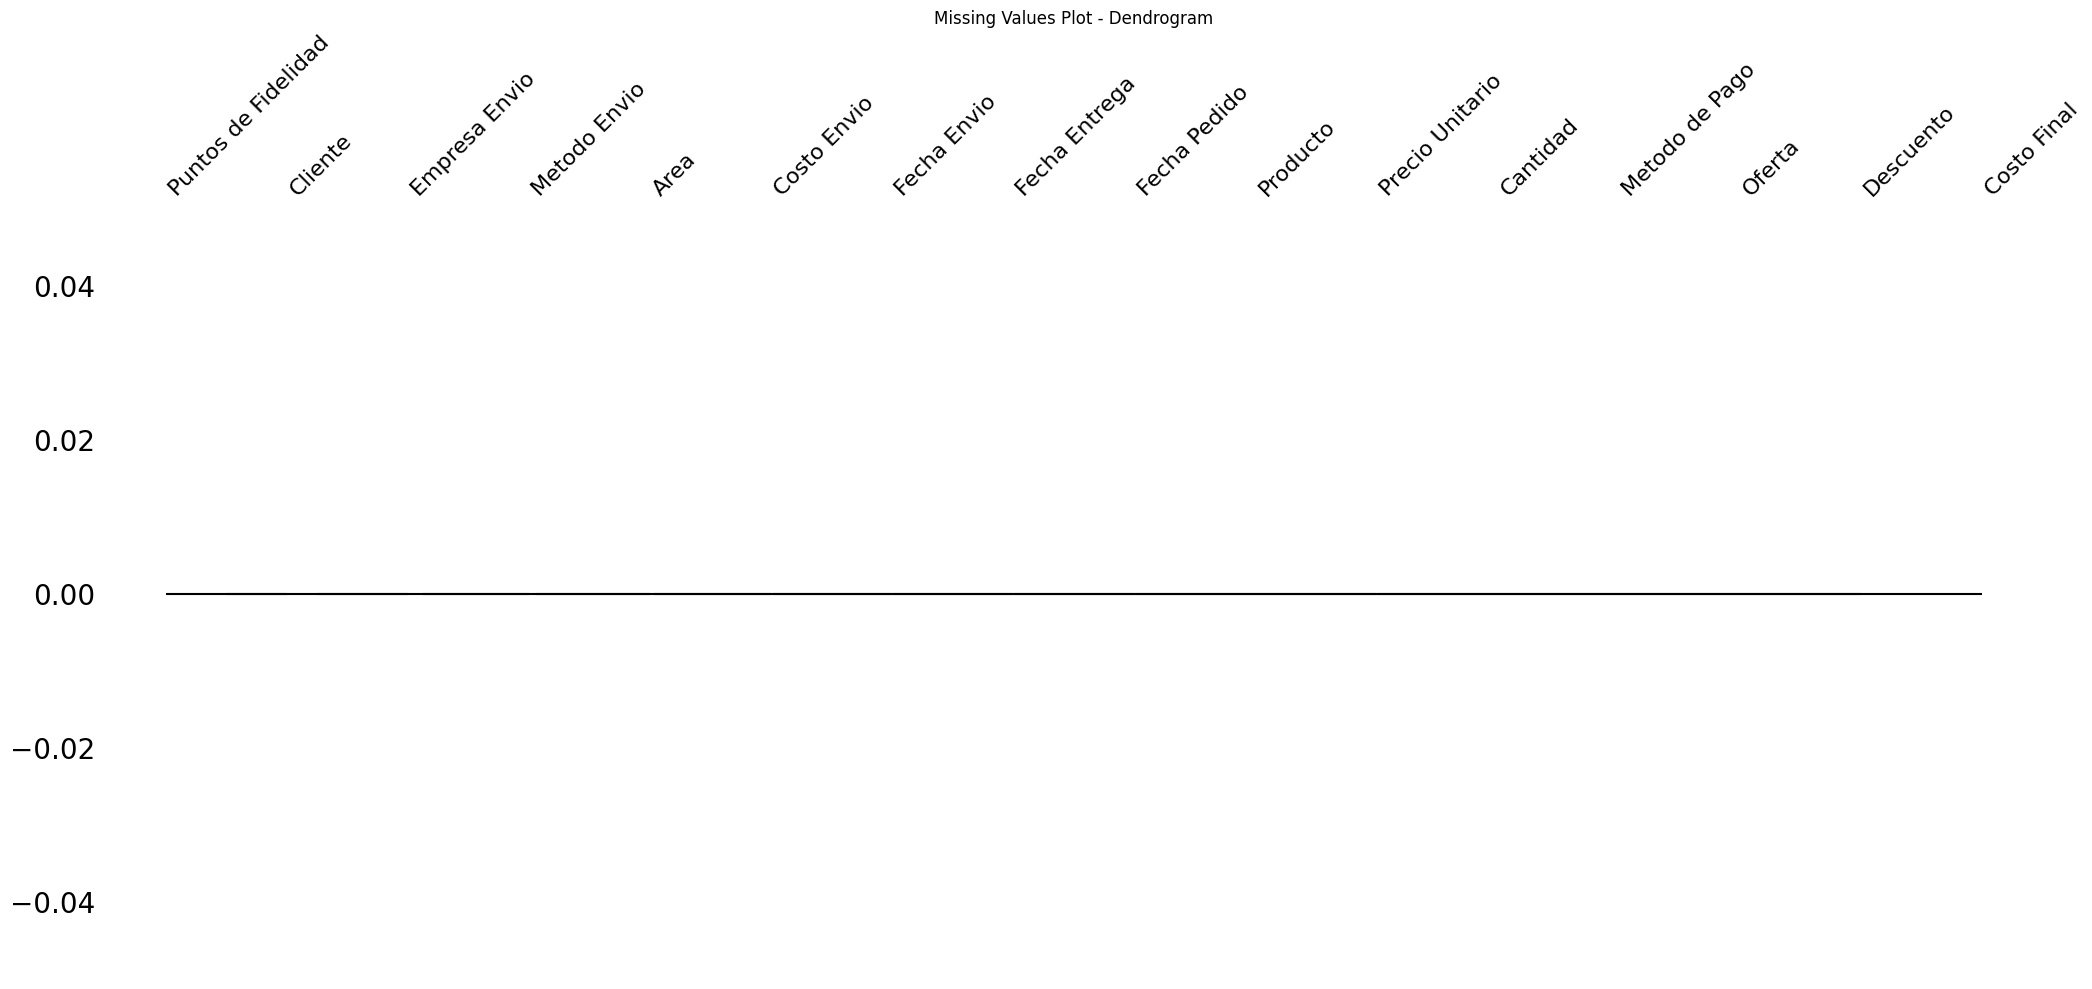

In [50]:
eda.missingValuesPlot(plot="dendrogram")

## Informe sobre la Calidad de los Datos: Análisis de Valores Faltantes

### Interpretación del Dendrograma

El dendrograma proporcionado muestra la relación entre las columnas del DataFrame con respecto a los valores faltantes. A continuación, se detallan las conclusiones derivadas de la interpretación del gráfico:

1. **No hay valores faltantes significativos**:
    - Observación: Todas las columnas están alineadas en el nivel 0 del eje Y.
    - Interpretación: Esta alineación sugiere que no hay valores faltantes significativos en ninguna de las columnas del DataFrame. Las columnas no presentan variabilidad en términos de datos ausentes, lo que indica una uniformidad en la completitud de los datos.

2. **Datos completos**:
    - Observación: La ausencia de agrupaciones o ramas distintas en el dendrograma.
    - Interpretación: La presencia de las columnas en el mismo nivel y sin formar agrupaciones o ramas separadas indica que las columnas del DataFrame tienen datos completos. No se observa ningún patrón distintivo de valores faltantes que destaque entre las diferentes columnas.

### Conclusión

El análisis del dendrograma revela que el DataFrame está compuesto por datos completos, sin valores faltantes significativos. Este resultado es ideal para el análisis de datos, ya que evita la necesidad de realizar tareas de imputación o eliminación de valores faltantes. Esto permite proceder con análisis más avanzados o el desarrollo de modelos de machine learning sin la preocupación de sesgos o inconsistencias introducidas por la ausencia de datos.


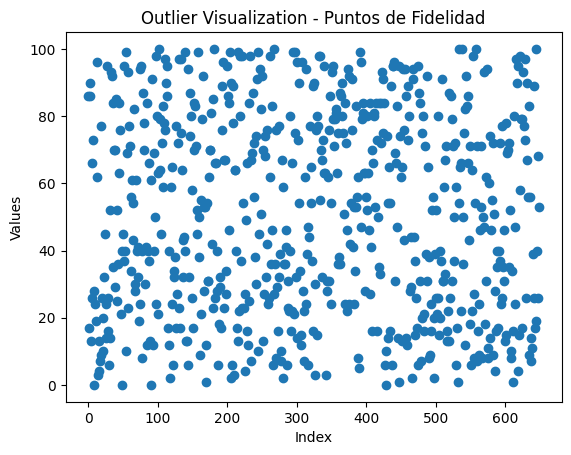

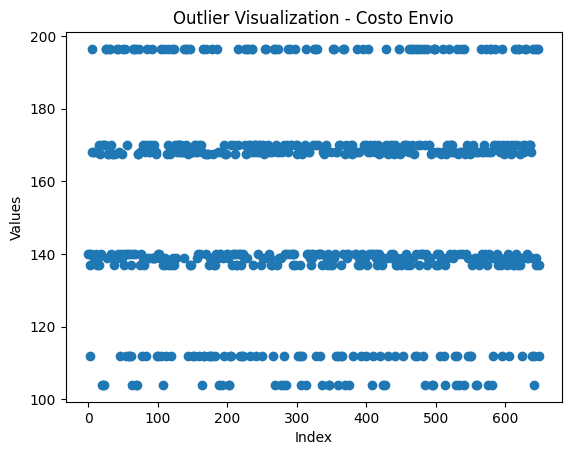

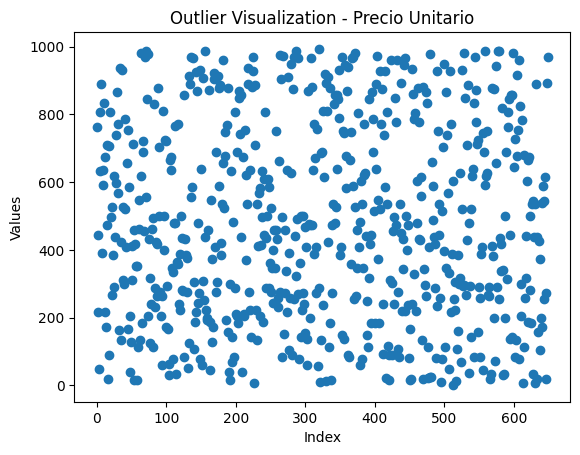

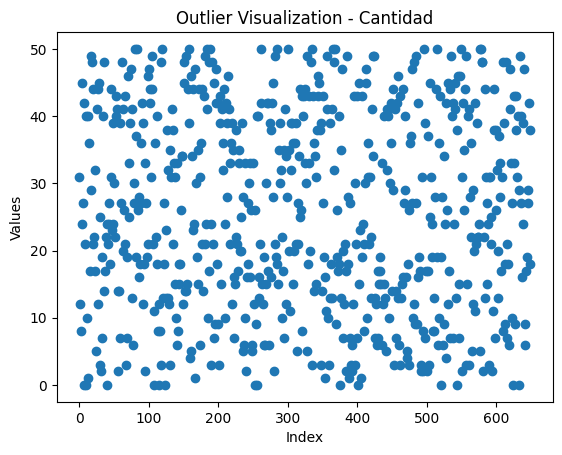

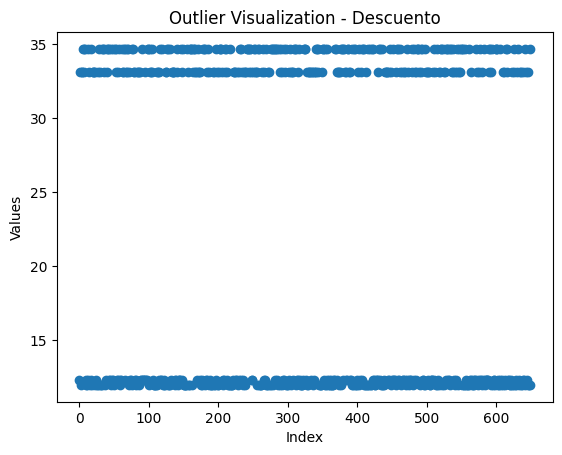

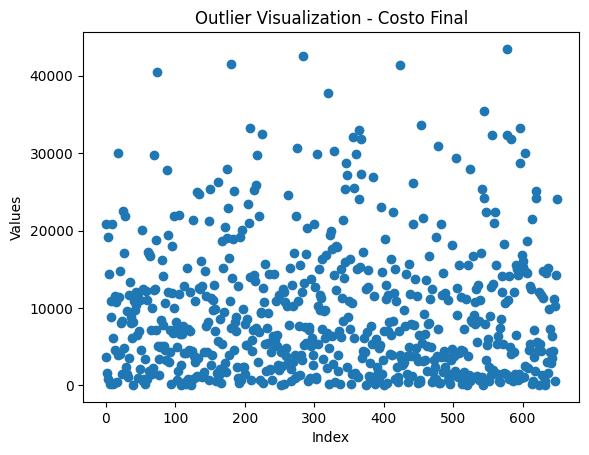

In [51]:
eda.outliersVisualization(plot="scatter")

# Informe de Análisis de Gráficos de Dispersión

## Gráfico 1: Puntos de Fidelidad

1. **Distribución de Puntos**: Los puntos están dispersos uniformemente a lo largo del gráfico, lo que sugiere que no hay un patrón claro en los "Puntos de Fidelidad" con respecto al índice.
2. **Rango de Valores**: El eje y (etiquetado como "Values") muestra que los "Puntos de Fidelidad" varían desde 0 hasta 100.
3. **Eje X (Índice)**: El eje x (etiquetado como "Index") parece representar la posición o índice de cada observación, que va de 0 a más de 600.
4. **Visualización de Outliers**: No se observan outliers obvios en este gráfico, ya que los puntos parecen estar uniformemente distribuidos dentro del rango esperado (0-100).

### Observaciones Clave:

- **No hay un patrón claro**: La dispersión uniforme de los puntos sugiere que los "Puntos de Fidelidad" no siguen un patrón discernible con respecto al índice.
- **Variabilidad de Datos**: Los "Puntos de Fidelidad" varían ampliamente, cubriendo todo el rango de 0 a 100.
- **Ausencia de Outliers Evidentes**: No hay puntos que se desvíen significativamente del rango general de valores, lo que sugiere que no hay valores atípicos destacados.

Este gráfico de dispersión es útil para visualizar la distribución general y la variabilidad de los "Puntos de Fidelidad", mostrando que están bastante distribuidos sin un patrón obvio de acumulación o concentración.

## Gráfico 2: Costo Envío

1. **Distribución de Puntos**: Los puntos en el gráfico están agrupados en varios niveles horizontales, lo que sugiere que el "Costo Envío" toma valores discretos específicos.
2. **Rango de Valores**: El eje y (etiquetado como "Values") muestra que los costos de envío varían desde 100 hasta 200.
3. **Eje X (Índice)**: El eje x (etiquetado como "Index") parece representar la posición o índice de cada observación, que va de 0 a más de 600.
4. **Patrones Horizontales**: Hay varias líneas horizontales distintivas que indican niveles comunes de costos de envío:
   - Alrededor de 120
   - Alrededor de 140
   - Alrededor de 160
   - Alrededor de 180
   - Alrededor de 200

### Observaciones Clave:

- **Valores Discretos**: El "Costo Envío" parece estar limitado a ciertos valores discretos en lugar de ser continuo.
- **Niveles Comunes**: Los costos de envío más comunes están alrededor de 120, 140, 160, 180, y 200.
- **Agrupación Clara**: La agrupación de los puntos en líneas horizontales sugiere que hay tarifas estándar para el costo de envío en los datos.

Este gráfico de dispersión es útil para visualizar cómo los costos de envío se distribuyen y muestra que hay ciertos valores discretos que se repiten frecuentemente en los datos.

## Gráfico 3: Precio Unitario

1. **Distribución de Datos**: Los puntos parecen estar distribuidos aleatoriamente en todo el rango de valores del eje Y (de 0 a 1000). No hay una clara concentración de puntos en una región específica.
2. **Identificación de Valores Atípicos**: Para identificar outliers, podríamos buscar puntos que se desvíen significativamente del patrón general de la mayoría de los datos. Sin embargo, a simple vista, no parece haber puntos claramente fuera de lugar.
3. **Densidad de Puntos**: Aunque los puntos están bastante dispersos, podemos notar algunas áreas con mayor densidad de puntos, lo que sugiere que ciertos rangos de precios unitarios ocurren con más frecuencia que otros.
4. **Rango de Valores**: El rango de precios unitarios va de 0 a 1000. Esto podría indicar que los datos incluyen una amplia gama de precios unitarios.

Para un análisis más detallado, sería útil conocer el contexto de estos datos (por ejemplo, el tipo de producto o servicio), así como realizar estadísticas descriptivas (media, mediana, moda, desviación estándar) y técnicas de detección de outliers (como el método IQR o Z-score).

## Gráfico 4: Cantidad

1. **Distribución de Datos**: Los puntos también parecen estar distribuidos aleatoriamente en todo el rango de valores del eje Y (de 0 a 50). No hay una clara concentración de puntos en una región específica.
2. **Identificación de Valores Atípicos**: Similar al gráfico anterior, los valores atípicos se identificarían buscando puntos que se desvíen significativamente del patrón general. A primera vista, no hay puntos que se destaquen claramente como outliers.
3. **Densidad de Puntos**: Aunque los puntos están dispersos, hay algunas áreas con una mayor concentración de puntos, lo que sugiere que ciertas cantidades ocurren con más frecuencia que otras.
4. **Rango de Valores**: El rango de cantidades va de 0 a 50. Esto podría indicar que los datos incluyen una amplia gama de cantidades posibles.

En resumen, ambos gráficos muestran datos distribuidos de manera bastante uniforme sin patrones claros de agrupación o valores atípicos evidentes. Para un análisis más profundo, sería útil realizar estadísticas descriptivas y aplicar técnicas de detección de outliers, como el análisis de percentiles o el uso del método de Tukey (IQR). También podría ser útil contextualizar los datos para comprender mejor qué representa cada punto y qué variaciones son esperables.

## Gráfico 5: Descuento

1. **Distribución de Datos**: A diferencia de los gráficos anteriores, los datos aquí parecen estar agrupados en dos niveles principales en el eje Y, uno alrededor de 15 y otro alrededor de 35.
2. **Valores Atípicos**: Dado que los datos están agrupados en dos niveles claros, cualquier punto que no se alinee con estos niveles podría considerarse un outlier. Sin embargo, en este gráfico, no se observan claramente valores fuera de estos dos niveles.
3. **Patrones de Descuento**: Los datos sugieren que los descuentos se aplican en dos niveles distintos y específicos, posiblemente indicando dos políticas o categorías de descuento.
4. **Rango de Valores**: El rango de descuentos va de 0 a 50, pero los datos se agrupan alrededor de dos valores específicos, lo que sugiere que la mayoría de los descuentos se aplican en estos dos niveles.

Este patrón puede ser indicativo de una estructura de descuentos que se aplica consistentemente en dos niveles diferentes, posiblemente para diferentes productos o segmentos de clientes. Para un análisis más detallado, se podría investigar por qué existen estos dos niveles específicos de descuento y si hay alguna regla de negocio o política que los explique.

## Gráfico 6: Costo Final

1. **Distribución de Datos**: La mayoría de los puntos de datos se encuentran por debajo de los 20,000, lo que sugiere que la mayor parte de los costos finales están en ese rango.
2. **Outliers**: Se pueden observar algunos puntos que están significativamente más altos que el resto, alrededor de los 30,000 y 40,000. Estos puntos son outliers, ya que están fuera del rango donde se concentra la mayoría de los datos.
3. **Patrón de Dispersión**: No parece haber un patrón claro en la dispersión de los datos, indicando que los costos finales varían bastante en todos los índices.